Looking at the skew and kurtosis of sale price

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import boxcox, skew, kurtosis
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from config_local import local_config  # provides TRAIN_CSV, TEST_CSV, SUBMISSIONS_DIR

In [2]:
train = pd.read_csv(local_config.TRAIN_OUTLIER_FILLED_CSV)   # e.g. data/train_filled.csv           
test = pd.read_csv(local_config.TEST_FILLED_CSV)    # e.g. data/test_filled.csv

In [3]:
salePriceReshape = train["SalePrice"].values.reshape(-1, 1)

salePrice_df = pd.DataFrame(columns = ['SalePrice', 'logSP', 'SquareRootSP', 'BoxCoxSP', 'YeoJohnsonSP', 'QuantileSP', 'QuantileSP'])
transforms = {
    "SalePrice": lambda x: x.ravel(),
    "logSP": lambda x: np.log1p(x).ravel(),
    "SquareRootSP": lambda x: np.sqrt(x).ravel(),
    "BoxCoxSP": lambda x: boxcox(x.ravel())[0],  # BoxCox returns (vals, lambda)
    "YeoJohnsonSP": lambda x: PowerTransformer(method="yeo-johnson").fit_transform(x).ravel(),
    "QuantileSP": lambda x: QuantileTransformer(output_distribution="normal", random_state=0).fit_transform(x).ravel()
}
salePrice_df = pd.DataFrame({name: func(salePriceReshape) for name, func in transforms.items()})
salePrice_df.head(3)

,SalePrice,logSP,SquareRootSP,BoxCoxSP,YeoJohnsonSP,QuantileSP
0,208500,12.247699,456.618002,7.924174,0.570934,0.624033
1,181500,12.109016,426.028168,7.869963,0.227643,0.312015
2,223500,12.317171,472.757866,7.951114,0.741527,0.763081


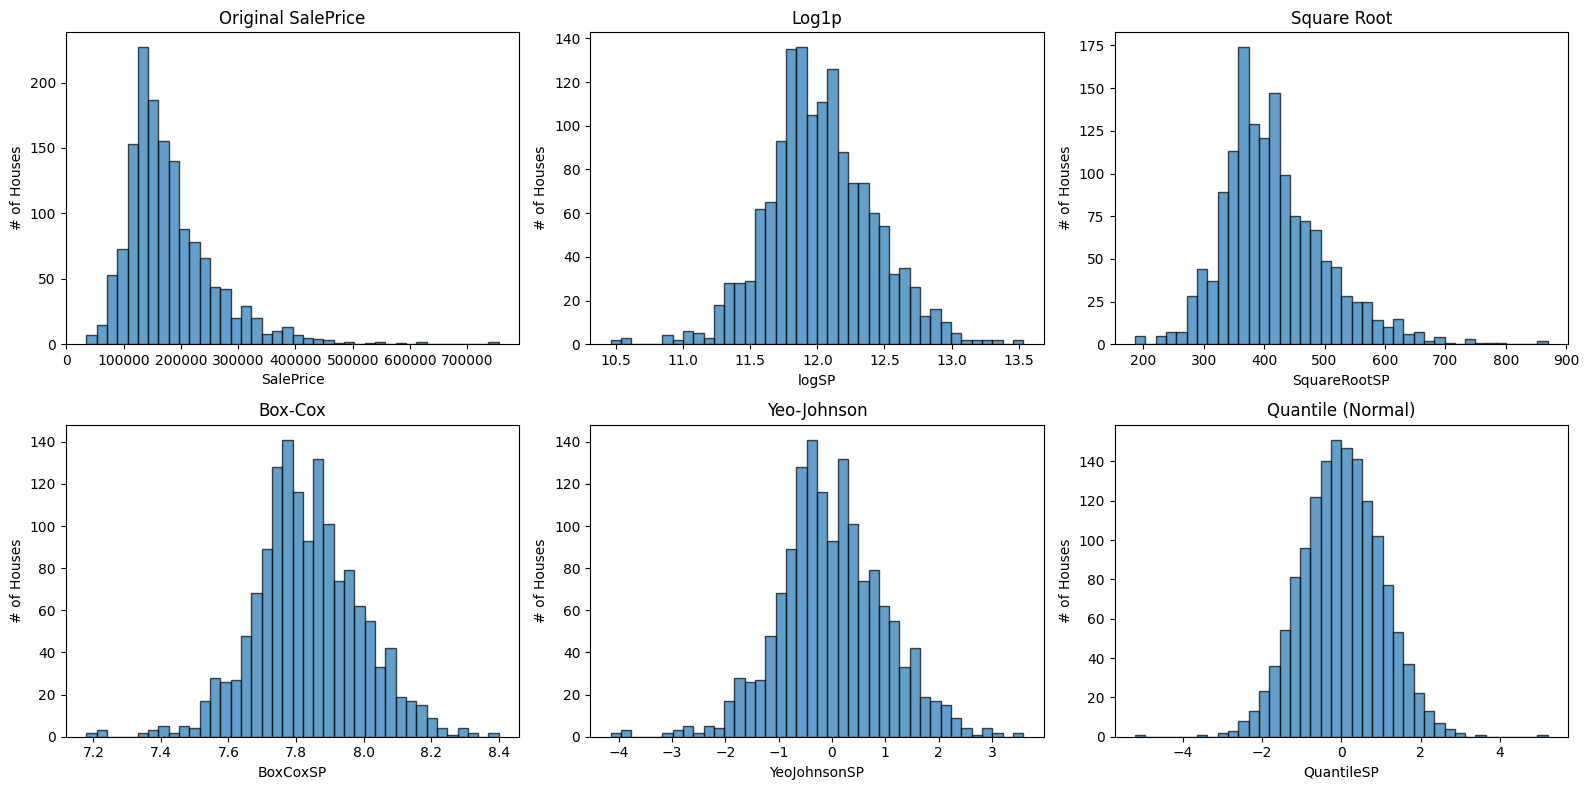

In [4]:
def plot_transforms(df):
    cols = [
        ("SalePrice", "Original SalePrice"),
        ("logSP", "Log1p"),
        ("SquareRootSP", "Square Root"),
        ("BoxCoxSP", "Box-Cox"),
        ("YeoJohnsonSP", "Yeo-Johnson"),
        ("QuantileSP", "Quantile (Normal)")
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.ravel()
    
    for ax, (col, title) in zip(axes, cols):
        if col in df.columns:
            ax.hist(df[col], bins=40, edgecolor="k", alpha=0.7)
            ax.set_title(title)
            ax.set_xlabel(col)
            ax.set_ylabel('# of Houses')
            
    plt.tight_layout()
    plt.show()

# Usage:
plot_transforms(salePrice_df)

In [5]:
train_outlier_filled_log1 = pd.read_csv(local_config.TRAIN_OUTLIER_FILLED_CSV) 
train_outlier_filled_log1["logSP"] = salePrice_df['logSP']
if "SalePrice" in train_outlier_filled_log1.columns:
    train_outlier_filled_log1 = train_outlier_filled_log1.drop(columns=["SalePrice"])

In [6]:
train_outlier_filled_log1.to_csv(__import__("pathlib").Path(local_config.TRAIN_OUTLIER_FILLED_LOG1_CSV).resolve().parent / "train_outlier_filled_log1.csv", index=False)
salePrice_df.to_csv(__import__("pathlib").Path(local_config.SALEPRICE_TRANSFORMS_CSV).resolve().parent / "salePrice_transforms.csv", index=False)

# Looking at the law of saleprices and the residual tails

In [7]:
from utils.checks import evaluate_many

distribCheck = evaluate_many({
    "SalePrice": train["SalePrice"],
    "logSP": train_outlier_filled_log1["logSP"],
})

# See the tidy table
distribCheck.sort_values(["series", "metric"]).head(30)

,series,metric,value,threshold,pass,note,overall_pass
1,SalePrice,abs_excess_kurt,6.523,1.00,False,,False
0,SalePrice,abs_skew,1.881,0.50,False,,False
3,SalePrice,jb_pvalue,0.000,0.05,False,>= alpha passes,False
2,SalePrice,jb_stat,3422.283,NaN,None,smaller is better,False
4,SalePrice,ks_norm,0.123,0.08,False,,False
6,logSP,abs_excess_kurt,0.805,1.00,True,,False
5,logSP,abs_skew,0.122,0.50,True,,False
8,logSP,jb_pvalue,0.000,0.05,False,>= alpha passes,False
7,logSP,jb_stat,42.259,NaN,None,smaller is better,False
9,logSP,ks_norm,0.040,0.08,True,,False
